# FIUBA
## CEIA - Introducción a Inteligencia Artificial
## Examen
Fernando Emir Garade

**1. Responder las siguientes preguntas teóricas: link.**  

**2. Pre-procesamiento del dataset:**

    a. Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

    b. Levantar el dataset en un arreglo de Numpy. 

    c. Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

    d. Partir el dataset en train (80%) y test (20%).

**3. Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma** 

y = [Wn … W0] * [X^n    X^(n-1)    …    1]. 

    a. Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

    b. Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

    c. Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código). 

    d. Graficar el polinomio obtenido y el dataset de test. 

**4. Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).**

    a. Para cada epoch, calcular el error de train y el error de validation. 

    b. Graficar el error de train y el error de validación en función del número de epoch.

    c. Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).

**5. Para el mejor modelo seleccionado en (3c), hacer la optimización utilizando Mini-Batch y regularización Ridge.**

    a. Computar el gradiente de J y codificar en Numpy la implementación del gradiente.

    b. Comparar con el modelo obtenido en (4).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Ejercicio 2: Pre-procesamiento del dataset

### a. Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

### b. Levantar el dataset en un arreglo de Numpy. 

In [62]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('X', np.float),
                     ('y', np.float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv))
            data = np.fromiter(data_gen, structure)

        return data

    def split(self, percentage):  # 0.8
        X = self.dataset['X']
        y = self.dataset['y']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test

In [75]:
dataset = Data('data\clase_8_dataset.csv')

In [76]:
X = dataset._build_dataset('data\clase_8_dataset.csv')['X']
y = dataset._build_dataset('data\clase_8_dataset.csv')['y']

### c. Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

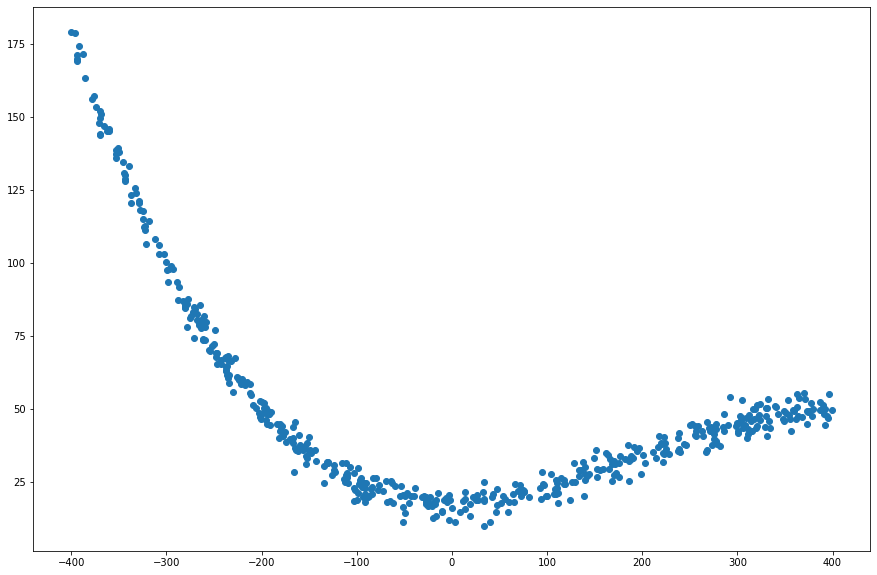

In [77]:
plt.subplots(figsize=(15,10))
plt.scatter(X, y)

### d. Partir el dataset en train (80%) y test (20%).

In [78]:
X_train, X_test, y_train, y_test = dataset.split(0.8)

## Ejercicio 3: Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma y = [Wn … W0] * [X^n    X^(n-1)    …    1].

In [142]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented

class LinearRegression(BaseModel):

    def fit(self, X, y):
        if len(X.shape) == 1:
            W = X.T.dot(y) / X.T.dot(X)
        else:
            W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.model = W

    def predict(self, X):
        return X.dot(self.model)

In [143]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

In [144]:
def k_folds(X_train, y_train, k=5):
    l_regression = LinearRegression()
    error = MSE()
    w_list=[]

    chunk_size = int(len(X_train) / k)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression.fit(new_X_train, new_y_train)
        prediction = l_regression.predict(new_X_valid)
        w_list.append(l_regression.model)
        mse_list.append(error(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)

    return mean_MSE

### a. Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

In [145]:
X_train_1 = np.vstack((X_train, np.ones(len(X_train)))).T

In [150]:
k_folds(X_train_1, y_train, k=5)

834.6960027160342

### b. Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

In [152]:
X_train_2 = np.vstack((np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
X_train_3 = np.vstack((np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
X_train_4 = np.vstack((np.power(X_train, 4), np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T

In [153]:
k_folds(X_train_2, y_train, k=5)

100.12294444150382

In [154]:
k_folds(X_train_3, y_train, k=5)

9.839364275961861

In [155]:
k_folds(X_train_4, y_train, k=5)

9.874519460016591

### c. Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código).

El modelo de grado 3 y 4 tienen un error cuadrático medio muy parecido, incluso el de 3° orden es menor. Elijo el polinomio de 3° grado ya que también es un modelo más simple.

### d. Graficar el polinomio obtenido y el dataset de test. 

In [158]:
X_test_3 = np.vstack((np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T

In [159]:
reglin = LinearRegression()
reglin.fit(X_train_3, y_train)
prediction = reglin.predict(X_test_3)

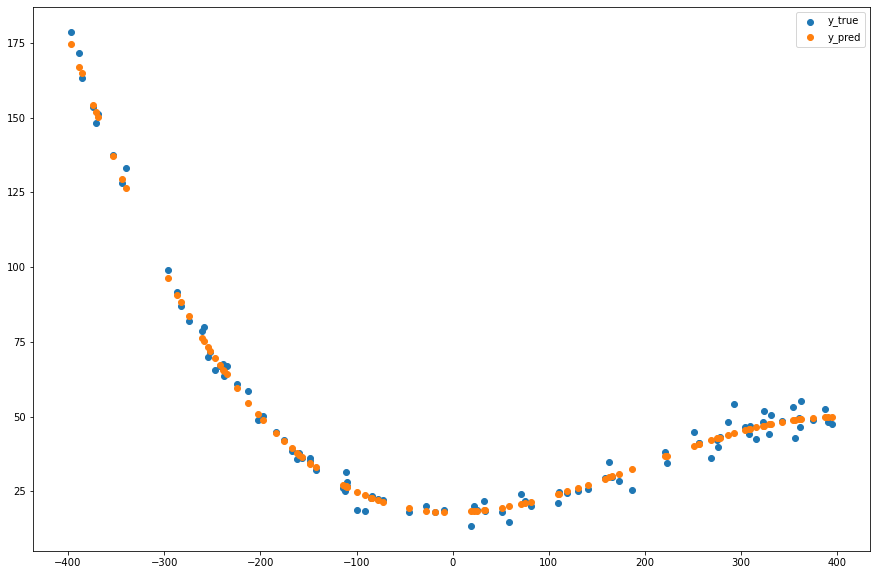

In [163]:
plt.subplots(figsize=(15,10))
plt.scatter(X_test, y_test, label='y_true')
plt.scatter(X_test, prediction, label='y_pred')
plt.legend()
plt.show()

## 4. Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).

In [177]:
def mini_batch_gradient_descent(X_train, y_train, lr=0.01, amt_epochs=100):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 10
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)

    for i in range(amt_epochs):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        batch_size = int(len(X_train) / b)
        for i in range(0, len(X_train), batch_size):
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end]
            batch_y = y_train[i: end]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(batch_X * error, axis=0)
            grad_mul = -2/n * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)

    return W

In [173]:
def k_folds_mini_batch(X_train, y_train, k=5):
    l_regression = mini_batch_gradient_descent(X_train,y_train,lr=0.01,amt_epochs=50)
    error = MSE()
    w_list=[]

    chunk_size = int(len(X_train) / k)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        #l_regression.fit(new_X_train, new_y_train)
        prediction = l_regression.dot(new_X_valid)
        w_list.append(l_regression)
        mse_list.append(error(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)

    return mean_MSE

### a. Para cada epoch, calcular el error de train y el error de validation. 

In [219]:
X_train_3_estandarizado = (X_train_3[:,:3] - X_train_3[:,:3].mean(axis=0)) / X_train_3[:,:3].std(axis=0)

In [221]:
X_train_3_estandarizado.shape

(400, 3)

In [223]:
X_train_3_estandarizado_with_ones = np.vstack((X_train_3_estandarizado, np.ones(X_train_3_estandarizado.shape[0]))).T

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 400

In [218]:
X_train_3[:,:3]

array([[-2.21241152e+07,  7.88092643e+04, -2.80729878e+02],
       [ 9.19515693e+05,  9.45597024e+03,  9.72418132e+01],
       [-1.91326197e+07,  7.15346231e+04, -2.67459573e+02],
       ...,
       [ 5.24981991e+02,  6.50773116e+01,  8.06705099e+00],
       [-1.09963629e+06,  1.06536733e+04, -1.03216633e+02],
       [ 3.85352597e+05,  5.29548238e+03,  7.27700651e+01]])

In [191]:
from sklearn.preprocessing import StandardScaler

In [224]:
stdscl = StandardScaler()
X_train_3_centrado_con_sklearn = stdscl.fit_transform(X_train_3)

In [225]:
stdscl.mean_

array([ 3.79739333e+05,  5.29218535e+04, -6.90621715e+00,  1.00000000e+00])

In [226]:
X_train_3.mean(axis=0)

array([ 3.79739333e+05,  5.29218535e+04, -6.90621715e+00,  1.00000000e+00])

In [227]:
stdscl.var_

array([5.34772143e+14, 2.06780675e+09, 5.28741577e+04, 0.00000000e+00])

In [228]:
X_train_3.var(axis=0)

array([5.34772143e+14, 2.06780675e+09, 5.28741577e+04, 0.00000000e+00])

In [229]:
mini_batch_gradient_descent(X_train_3_centrado_con_sklearn, y_train.reshape(-1, 1), lr=0.05, amt_epochs=100000)

array([[-23.31553338],
       [ 27.31057672],
       [  0.24485255],
       [ -0.0902225 ]])

Con Sklearn funciona bien la estandarización, tengo que afinar la estandarización manual con numpy

### b. Graficar el error de train y el error de validación en función del número de epoch.

### c. Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).